# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand profile for each cluster


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/churnometer/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/churnometer'

---

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .drop(['customerID', 'TotalCharges', 'Churn', 'tenure' ],axis=1) 
)
print(df.shape)
df.head(3)

(7043, 17)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85


# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [5]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### PCA
from sklearn.decomposition import PCA

### ML algorithm
from sklearn.cluster import KMeans


def PipelineCluster():
  pipeline_base = Pipeline([
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']) ),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                          threshold=0.6, selection_method="variance") ),

      ("scaler", StandardScaler()  ),  

      ("PCA", PCA(n_components=50, random_state=0) ), 

      ("model", KMeans(n_clusters=50, random_state=0)    ), 


  ])
  return pipeline_base

## Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(7043, 12) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 12 components explain 100.0% of the data 



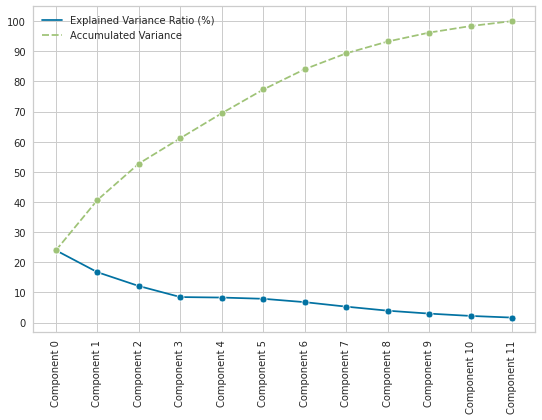

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 12

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9,6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

In [ ]:
pca_components_analysis(df_pca=df_pca,n_components=6)

In [7]:
def PipelineCluster():
  pipeline_base = Pipeline([
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']) ),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                          threshold=0.6, selection_method="variance") ),

      ("scaler", StandardScaler()  ),  

      ("PCA", PCA(n_components=6, random_state=0) ),  ### we update n_components to 6

      ("model", KMeans(n_clusters=50, random_state=0)    ), 


  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', P

## Elbow Method and Silhoutte Score

In [8]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(7043, 6) 
 <class 'numpy.ndarray'>


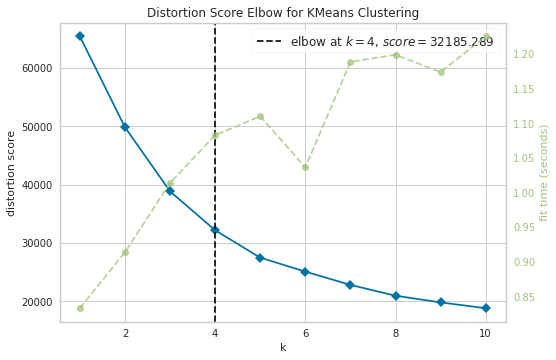

In [11]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


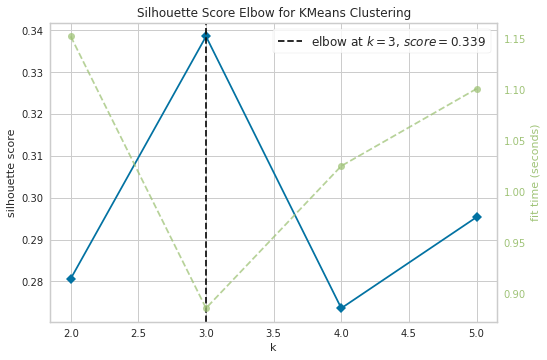



=== Silhoutte plot for 2 Clusters ===


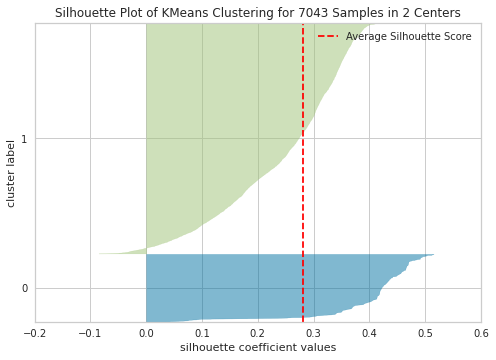



=== Silhoutte plot for 3 Clusters ===


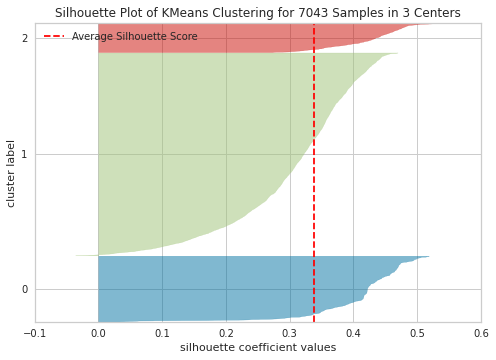



=== Silhoutte plot for 4 Clusters ===


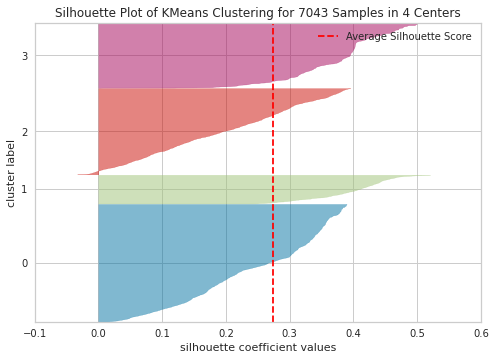



=== Silhoutte plot for 5 Clusters ===


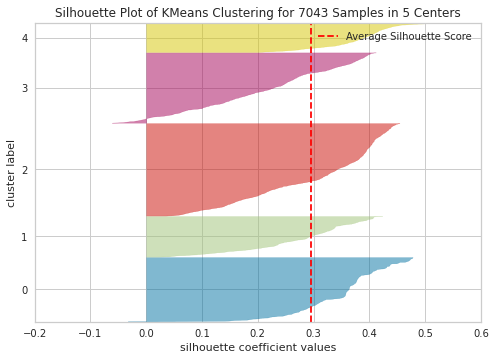

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 6 # 6 is not inclusive, it will go up to 5 in fact

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(n_cluster_start,n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start,stop=n_cluster_stop):
  
  print(f"=== Silhoutte plot for {n_clusters} Clusters ===")
  visualizer = SilhouetteVisualizer(estimator = KMeans(n_clusters=n_clusters, random_state=0),
                                    colors = 'yellowbrick')
  visualizer.fit(df_analysis)
  visualizer.show()
  plt.show()
  print("\n")

In [ ]:
def PipelineCluster():
  pipeline_base = Pipeline([
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']) ),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                          threshold=0.6, selection_method="variance") ),

      ("scaler", StandardScaler()  ),  

      ("PCA", PCA(n_components=6, random_state=0) ), 

      ("model", KMeans(n_clusters=3, random_state=0) ),  ### we update n_clusters to 3


  ])
  return pipeline_base

PipelineCluster()

## Fit Cluster Pipeline

Quick recap in our data for training cluster pipeline

In [ ]:
X = df.copy()
print(X.shape)
X.head(3)

Fit Cluster pipeline

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [ ]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

Let's visualize the PCA components and the clusters
* To simplify, we will make a 2D scatter plot
* We will plot the first 2 PCA components (since they have the most data variance) and color by the clusters
    * Each datapoint is a user and belongs to a given cluster (0, 1 or 2)
    * As we have studied, the PCA components are a combination from the original features, so we don't have a single interpreration for it. We are just plotting the 2 major components after we apply PCA. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_analysis[:,0], y= df_analysis[:,1], hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x",s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

Here we are saving the cluster predictions from this pipeline to use in a fututre moment. We will get back to that in a later stage

In [ ]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

## Fit a classifier, where target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [ ]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

Split Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, X_test.shape)

Create a classifier pipeline 
* We add a feature selection step that will tell the most relevant features to that pipeline
* We are considering a model that typically offers good results and features importance can be assessed with `.features_importance_`

In [ ]:
### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithm
from sklearn.ensemble import GradientBoostingClassifier 

def PipelineClf2ExplainClusters():
  pipeline_base = Pipeline([
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']) ),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                          threshold=0.6, selection_method="variance") ),

      ("scaler", StandardScaler()  ),  

      ("feat_selection", SelectFromModel(GradientBoostingClassifier(random_state=0)) ) , 

      ("model", GradientBoostingClassifier(random_state=0) ),  

  ])
  return pipeline_base


PipelineClf2ExplainClusters()


Fit the classifier to the training data

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

## Evaluate classifier performance on Train and Test Sets

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

## Assess Most Important Features that define a cluster

In [ ]:
# after data cleaning and feat engineering, the feature space changes

data_cleaning_feat_eng_steps = 2 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
          'Importance': pipeline_clf_cluster['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Feature'].to_list() # reassign best features in importance order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

We will store the best_features for future usage. We will get back to that in a later stage

In [ ]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

## Cluster Analysis

Load function that plots a table with description for all Clusters

In [ ]:

def DescriptionAllClusters(df, decimal_points=3):

  DescriptionAllClusters = pd.DataFrame(columns=df.drop(['Clusters'],axis=1).columns)
  # iterate on each cluster , calls Clusters_IndividualDescription()
  for cluster in df.sort_values(by='Clusters')['Clusters'].unique():
    
      EDA_ClusterSubset = df.query(f"Clusters == {cluster}").drop(['Clusters'],axis=1)
      ClusterDescription = Clusters_IndividualDescription(EDA_ClusterSubset,cluster,decimal_points)
      DescriptionAllClusters = DescriptionAllClusters.append(ClusterDescription)

  
  DescriptionAllClusters.set_index(['Cluster'],inplace=True)
  return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster,cluster, decimal_points):

  ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
  # for a given cluster, iterate in all columns
  # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
  # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

  for col in EDA_Cluster.columns:
    
    try:  # eventually a given cluster will have only mssing data for a given variable
      
      if EDA_Cluster[col].dtypes == 'object':
        
        top_frequencies = EDA_Cluster.dropna(subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
        Description = ''
        
        for x in range(len(top_frequencies)):
          freq = top_frequencies.iloc[x]
          category = top_frequencies.index[x][0]
          CategoryPercentage = int(round(freq*100,0))
          statement =  f"'{category}': {CategoryPercentage}% , "  
          Description = Description + statement
        
        ClustersDescription.at[0,col] = Description[:-2]


      
      elif EDA_Cluster[col].dtypes in ['float', 'int']:
        DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
        Q1 = round(DescStats.iloc[4,0], decimal_points)
        Q3 = round(DescStats.iloc[6,0], decimal_points)
        Description = f"{Q1} -- {Q3}"
        ClustersDescription.at[0,col] = Description
    
    
    except Exception as e:
      ClustersDescription.at[0,col] = 'Not available'
      print(f"** Error Exception: {e} - cluster {cluster}, variable {col}")
  
  ClustersDescription['Cluster'] = str(cluster)
  
  return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [ ]:
import plotly.express as px
def cluster_distribution_per_variable(df,target):

  # the data should have 2 variables, the cluster predictions and
  # the variable you want to analyze with, in this case we call "target"
  
  # we use plotly express to create 2 plots
  # cluster distribution across the target
  # relative presence of the target level in each cluster
  
   
  df_bar_plot = df.value_counts(["Clusters", target]).reset_index() 
  df_bar_plot.columns = ['Clusters',target,'Count']
  df_bar_plot[target] = df_bar_plot[target].astype('object')

  print(f"Clusters distribution across {target} levels")
  fig = px.bar(df_bar_plot, x='Clusters',y='Count',color=target,width=800, height=500)
  fig.update_layout(xaxis=dict(tickmode= 'array',tickvals= df['Clusters'].unique()))
  fig.show()


  df_relative = (df
                 .groupby(["Clusters", target])
                 .size()
                 .groupby(level=0)
                 .apply(lambda x:  100*x / x.sum())
                 .reset_index()
                 .sort_values(by=['Clusters'])
                 )
  df_relative.columns = ['Clusters',target,'Relative Percentage (%)']
 

  print(f"Relative Percentage (%) of {target} in each cluster")
  fig = px.line(df_relative, x='Clusters',y='Relative Percentage (%)',color=target,width=800, height=500)
  fig.update_layout(xaxis=dict(tickmode= 'array',tickvals= df['Clusters'].unique()))
  fig.update_traces(mode='markers+lines')
  fig.show()
 



Create a DataFrame that contains best features and Clusters Predictions, since we want to analyze the patterns for each cluster


In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

We want also to analyze Churn levels
* In this exercise, we get Churn by loading from collection folder and filtering Churn.
* We know in advance that Churn is encoded as an integer, even being an categorical variable. Therefore for this analysis we change its data type to `'object'`.

In [ ]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

### Cluster profile based on the best features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

# Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [ ]:
best_features_pipeline_all_variables

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a elbow method and silhouette plot and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!
* The **gain** is that in real time (which is the major purpose of Machine Learning) you will need less variables for predicting cluster for your prospects.

## Subset data with the most relevant variables

In [ ]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

## Rewrite Cluster Pipeline

In [ ]:
def PipelineCluster():
  pipeline_base = Pipeline([

      # we update the pipeline, considering only the most important variables from previous pipeline      
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                variables = ['OnlineBackup', 'PhoneService'] ) ),

      # it doesn't need SmartCorrelation

      ("scaler", StandardScaler()  ),  

      # No PCA step needed, since we know which features to consider

      ("model", KMeans(n_clusters=3, random_state=0) ),


  ])
  return pipeline_base

PipelineCluster()

## Apply Elbow Method and Silhoutte Score to the filtered data and compare to previous pipeline

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

Elbow Analysis

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(n_cluster_start,n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start,stop=n_cluster_stop):
  
  print(f"=== Silhoutte plot for {n_clusters} Clusters ===")
  visualizer = SilhouetteVisualizer(estimator = KMeans(n_clusters=n_clusters, random_state=0),
                                    colors = 'yellowbrick')
  visualizer.fit(df_analysis)
  visualizer.show()
  plt.show()
  print("\n")

## Fit New Cluster Pipeline

We set X as our training set for cluster. It is a copy of df_reduced

In [ ]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

Fit Cluster pipeline

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [ ]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" from the previous cluster

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [ ]:
cluster_predictions_with_all_variables

And these are the predictions from **current** cluster pipeline (trained with `['OnlineBackup', 'MonthlyCharges', 'PhoneService', 'Partner', 'Dependents']`)

In [ ]:
cluster_anwers_with_major_variables = X['Clusters'] 
cluster_anwers_with_major_variables

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**
* We say equivalent in quotes, because we can't expect that a cluster label 0 in the previous cluster will have the same label in the current cluster. Eventually label 0 in previous cluster pipeline will be a different label in current cluster pipeline
* When we reach this **equivalence**, it means both clusters "clustered" in a similar way but with different labels. And this is fine, since the label itself doesn't have meaning. We will look for the meaning after. 

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_anwers_with_major_variables))

Conclusion
* We see that both Clusters Pipelines are not predicting the data 100% equivalent, since few data points have different meaning for each pipeline. 
* However this is fine, and we say yes for this criteria. This is part of the trade-off we are up to.

## Fit a classifier, where target is cluster predictions and features remaining variables

We create a DataFrame `df_clf` as a copy of `X`

In [ ]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

Split Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, X_test.shape)

Rewrite pipeline to explain clusters

In [ ]:
def PipelineClf2ExplainClusters():
  pipeline_base = Pipeline([
   
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                              variables = ['OnlineBackup', 'PhoneService'] ) ),

    # it doesn't need SmartCorrelation

    ("scaler", StandardScaler()  ),  

    # we don't consdier feature selection step, since we know which features to consider 

    ("model", GradientBoostingClassifier(random_state=0) ),  

  ])
  return pipeline_base


PipelineClf2ExplainClusters()

## Fit a classifier, where target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

## Evaluate classifier performance on Train and Test Sets

In [ ]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

The performance on Train and Test sets are similar, comparing to the previous pipeline! :)

## Assess Most Important Features

In [ ]:
best_features = X_train.columns.to_list() # since we don't have feature selection step in this pipeline, best_features is Xtrain columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature':best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
.sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Cluster Analysis

Create a DataFrame that contains best features and Clusters Predictions: we want to analyze the patterns for each cluster


In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

We want also to analyze Churn levels

In [ ]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

### Cluster profile on most important features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct a elbow method and silhouette plot and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"


We are happy with all criteria above for the new Cluster Pipeline
* As a result, we will deploy the second pipeline. 
* Note: If the performance was equivalent from previous pipeline, we would have enough reason, but in fact it is better, since the average silhouette score increased in the pipeline with less variables, from 0.34 to 0.68.
* In addition, there is a great gain to have less variables for predicting live data

In [ ]:
pipeline_cluster

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Cluster pipeline

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

## Train Set

In [ ]:
print(df_reduced.shape)
df_reduced.head(3)

In [ ]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [ ]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell ouputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!